In [1]:
import random

import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import spacy
from convokit import Corpus, download
from langchain.agents import AgentExecutor, create_react_agent, load_tools
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import (
    AIMessagePromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_community.tools.google_scholar import GoogleScholarQueryRun
from langchain_community.utilities.google_scholar import GoogleScholarAPIWrapper
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

**Note:** Worked with Chanteria Milner on this assignment.

<img src="misc/syllabus_segment.png" style="width:400px">

# Constants, Utility Functions, and Data Importing

In [3]:
# Constants and clients
openai_client = OpenAI(temperature=0.9, model_name="gpt-3.5-turbo-instruct")

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [4]:
# Utility functions


def kl_divergence(x, y):
    P = x.copy()
    Q = y.copy()
    P.columns = ["P"]
    Q.columns = ["Q"]
    df = Q.join(P).fillna(0)
    p = df.iloc[:, 1]
    q = df.iloc[:, 0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl


def chi2_divergence(x, y):
    P = x.copy()
    Q = y.copy()
    P.columns = ["P"]
    Q.columns = ["Q"]
    df = Q.join(P).fillna(0)
    p = df.iloc[:, 1]
    q = df.iloc[:, 0]
    return scipy.stats.chisquare(p, q).statistic


def corpus_divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(
        list(freqP.values()), columns=["frequency"], index=list(freqP.keys())
    )
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(
        list(freqQ.values()), columns=["frequency"], index=list(freqQ.keys())
    )
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P["frequency"], Q["frequency"]).statistic
        except:
            return scipy.stats.ks_2samp(P["frequency"], Q["frequency"])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(
                P["frequency"], Q["frequency"], u_weights=None, v_weights=None
            ).statistic
        except:
            return scipy.stats.wasserstein_distance(
                P["frequency"], Q["frequency"], u_weights=None, v_weights=None
            )


def get_density(df):
    data = df
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data) - width / 5, np.max(data) + width / 5, 600)
    density.covariance_factor = lambda: 0.25
    density._compute_covariance()
    return xs, density(xs)


def draw_network(df, title):
    plt.figure(figsize=(8, 8))
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_, to_, weight=df.loc[from_][to_])

    pos = nx.spring_layout(G, k=0.55, iterations=20)
    edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())
    weights = np.array(weights)
    # weights = weights*weights
    weights = 6 * weights / np.max(weights)
    print(title)

    edge_colors = 20 * (weights / np.max(weights))
    edge_colors = edge_colors.astype(int)
    #     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
    #     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
    #     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(
        G,
        pos,
        with_labels=True,
        font_weight="bold",
        width=weights,
        edge_color=255 - edge_colors,
        node_color="#99cef7",
        node_size=1200,
        alpha=0.75,
        arrows=True,
        arrowsize=20,
    )
    return edge_colors


# extract laws from ner


def extract_laws(agg_ner: list):
    laws = []
    for entity, _type, count in agg_ner:
        if _type == "LAW":
            laws.append((entity, count))
    return laws


def create_system_message_prompt():
    """Creates a system message prompt"""
    personality_template = """
    The following is a conversation with an AI assistant that is used to help find 
    the most important topics in SCOTUS decisions as more decisions are fed into 
    the model.
    """
    return SystemMessagePromptTemplate.from_template(personality_template)


def create_chat_prompt(human, ai):
    """Creates a chat prompt template with human history, and AI history."""
    messages = [create_system_message_prompt()]

    for h, a in zip(human, ai):
        messages.append(HumanMessagePromptTemplate.from_template(h))
        messages.append(AIMessagePromptTemplate.from_template(a))

    messages.append(HumanMessagePromptTemplate.from_template("{input}"))
    return ChatPromptTemplate.from_messages(messages)


def query_chain(chain, input_text):
    """Queries the conversation chain with the given input."""
    return chain.run(input_text)

In [4]:
# Data importing
winning_args_corpus = Corpus(filename=download("winning-args-corpus"))

In [12]:
congress_ner_df = pd.read_feather("data/congress_legislation_ner.fea")

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other 
than 'subreddit-Cornell', including at least one function you find in the package 
not used above. You can also generate a ConvoKit Corpus from your own dataset based 
on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may 
be time-consuming for a weekly assignment.

In [5]:
winning_args_corpus.print_summary_stats()

Number of Speakers: 34911
Number of Utterances: 293297
Number of Conversations: 3051


In [6]:
# Number of utterances in the corpus (not used in homework)
len(winning_args_corpus.get_utterance_ids())

293297

In [7]:
# Show an utterance object (not used in homework)
unsuccessful_comments = 0
successful_comments = 0
utterance_ids = winning_args_corpus.get_utterance_ids()
for each in utterance_ids:
    # A successful comment has a value of 1, and an unsuccessful comment
    # has a value of 0
    if winning_args_corpus.get_utterance(each).meta["success"]:
        successful_comments += 1
    else:
        unsuccessful_comments += 1

In [8]:
print(f"Number of successful comments: {successful_comments:,.0f}")
print(f"Number of unsuccessful comments: {unsuccessful_comments:,.0f}")
print(
    f"Comment success rate: {successful_comments/(successful_comments+unsuccessful_comments)*100:,.2f}%"
)

Number of successful comments: 12,420
Number of unsuccessful comments: 280,877
Comment success rate: 4.23%


## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that perform a similar social 
similarity or influence analysis on a dataset relevant to your final project (__or 
one from ConvoKit__). Create relationships between actors in a network based on your 
dataset (e.g., person to person or document to document), and perform analyses that 
interrogate the structure of their interactions, similarity, and/or influence on 
one another. (For example, if relevant to your final project, you could explore 
different soap operas, counting how many times a character may have used the word 
love in conversation with another character, and identify if characters in love 
speak like each other. Or do opposites attract?) What does that analysis and its 
output reveal about the relative influence of each actor on others? What does it 
reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in 
which actors appear together), then calculate the most central actors in the 
`show.Realtime` output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [13]:
# subset the data and extract laws from ner
congress_ner_subset = congress_ner_df.sample(n=400, random_state=123).reset_index(
    drop=True
)
congress_ner_subset["cleaned_text_laws_agg"] = congress_ner_subset[
    "cleaned_text_ner_agg"
].apply(extract_laws)
congress_ner_subset.head()

,legislation number,url,congress,title,date proposed,amends amendment,latest summary,congress_num,bill_type,bill_num,...,cleaned_text,cleaned_summary,tokenized_text_sents,tokenized_text_words,tokenized_text_words_norm,cleaned_text_ner,cleaned_summary_ner,cleaned_text_ner_agg,cleaned_summary_ner_agg,cleaned_text_laws_agg
0,S. 1221,https://www.congress.gov/bill/104th-congress/s...,104th Congress (1995-1996),Legal Services Reform Act of 1996,NaN,NaN,<p>Legal Services Reform Act of 1996 - Revises...,104,s,1221,...,[Congressional Bills 104th Congress] [From the...,Legal Services Reform Act of 1996 Revises the ...,"[[congressional bills 104th congress], [from t...","[congressional, bills, congress, u., s., gover...","[congressional, bill, congress, u., s., govern...","[[Congressional, ORG], [the U. S. Government P...","[[Legal Services Reform Act, LAW], [1996, DATE...","[[the Congress of the United States, ORG, 14],...","[[Legal Services Corporation Act, LAW, 2], [th...","[(the Legal Services Corporation Act, 31), (se..."
1,H.R. 2052,https://www.congress.gov/bill/104th-congress/h...,104th Congress (1995-1996),International Population Stabilization and Rep...,NaN,NaN,<p>International Population Stabilization and ...,104,hr,2052,...,[Congressional Bills 104th Congress] [From the...,International Population Stabilization and Rep...,"[[congressional bills 104th congress], [from t...","[congressional, bills, congress, u., s., gover...","[congressional, bill, congress, u., s., govern...","[[Congressional, ORG], [the U. S. Government P...","[[International Population Stabilization, ORG]...","[[THE HOUSE OF REPRESENTATIVES, ORG, 20], [the...","[[International Population Stabilization, ORG,...","[(the Foreign Assistance Act, 12), (SECTION 1,..."
2,H.R. 4754,https://www.congress.gov/bill/108th-congress/h...,108th Congress (2003-2004),"Departments of Commerce, Justice, and State, t...",NaN,NaN,"<p>Departments of Commerce, Justice, and Stat...",108,hr,4754,...,[Congressional Bills 108th Congress] [From the...,"Departments of Commerce, Justice, and State, t...","[[congressional bills 108th congress], [from t...","[congressional, bills, congress, u., s., gover...","[congressional, bill, congress, u., s., govern...","[[Congressional Bills 108th Congress, ORG], [t...","[[Departments of Commerce, ORG], [Justice, ORG...","[[Congressional Bills 108th Congress, ORG, 1],...","[[Related Agencies Department of Commerce, ORG...","[(Legal Activities'', 2), (section 605 of this..."
3,H.R. 3355,https://www.congress.gov/bill/115th-congress/h...,115th Congress (2017-2018),Department of Homeland Security Appropriations...,NaN,NaN,<p>(This measure has not been amended since i...,115,hr,3355,...,[Congressional Bills 115th Congress] [From the...,(This measure has not been amended since it wa...,"[[congressional bills 115th congress], [from t...","[congressional, bills, congress, u., s., gover...","[congressional, bill, congress, u., s., govern...","[[Congressional Bills 115th Congress, ORG], [t...","[[FY2018, ORG], [the Department of Homeland Se...","[[Congressional Bills 115th Congress, ORG, 1],...","[[FY2018, ORG, 9], [the Department of Homeland...","[(section 1308(d, 18), (section 9703(g)(4)(B, ..."
4,H.J.Res. 133,https://www.congress.gov/bill/104th-congress/h...,104th Congress (1995-1996),Making further continuing appropriations for t...,NaN,NaN,<p>Makes continuing appropriations for FY 1996...,104,hjres,133,...,[Congressional Bills 104th Congress] [From the...,"Makes continuing appropriations for F Y 1996, ...","[[congressional bills 104th congress], [from t...","[congressional, bills, congress, u., s., gover...","[congressional, bill, congress, u., s., govern...","[[Congressional, ORG], [the U. S. Government P...","[[the District of Columbia, GPE], [Sec, ORG], ...","[[THE HOUSE OF REPRESENTATIVES, ORG, 3], [the ...","[[the District of Columbia, GPE, 1], [Sec, ORG...","[(section 111, 14), (section 1513, 2), (D. C. ..."


In [14]:
# extract references
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
nlp = spacy.load("en_core_web_sm")
law_names = congress_ner_subset["title"].tolist()
law_vectors = sentence_model.encode(law_names)

In [15]:
# initialize a column with empty lists
congress_ner_subset["references"] = [[] for _ in range(len(congress_ner_subset))]

for i, row in congress_ner_subset.iterrows():
    law_entities = row["cleaned_text_laws_agg"]

    for entity, count in law_entities:
        # Convert the law entity to vector
        entity_vector = sentence_model.encode([entity])

        # Calculate cosine similarity with all law vectors
        similarities = cosine_similarity(entity_vector, law_vectors)[0]

        # For significant similarities, update the references count
        for j, similarity in enumerate(similarities):
            if j == i:  # don't include self references
                continue
            if (
                similarity > 0.96
            ):  # Use a threshold to determine if it's considered a reference
                if len(congress_ner_subset.at[i, "references"]) < len(law_names):
                    # Ensure the references list is initialized properly
                    congress_ner_subset.at[i, "references"] = [0] * len(law_names)
                # Increment the count at the jth index by the count of references in the entity tuple
                print(
                    f"Entity: {entity}\nReference: {law_names[j]}\nSimilarity: {similarity:,.2f}"
                )
                congress_ner_subset.at[i, "references"][j] += int(count)

Entity: the Parental Notification and Intervention Act
Reference: Parental Notification and Intervention Act
Similarity: 0.99
Entity: the Child Custody Protection Act''
Reference: Child Custody Protection Act
Similarity: 0.98
Entity: the Child Interstate Abortion Notification Act''
Reference: Child Interstate Abortion Notification Act
Similarity: 0.98
Entity: the Child Interstate Abortion Notification Act''
Reference: Child Interstate Abortion Notification Act
Similarity: 0.98
Entity: the Child Interstate Abortion Notification Act''
Reference: Child Interstate Abortion Notification Act
Similarity: 0.98
Entity: the Born Alive Infants Protection Act
Reference: Born-Alive Infants Protection Act of 2002
Similarity: 0.96
Entity: the Informed Choice Act''
Reference: Informed Choice Act
Similarity: 0.97
Entity: the Informed Choice Act''
Reference: Informed Choice Act
Similarity: 0.97
Entity: the Born Alive Infants Protection Act
Reference: Born-Alive Infants Protection Act of 2002
Similarity:

In [17]:
# create the graph network
law_network = nx.Graph()
law_index_to_name = {
    i: law_name for i, law_name in enumerate(congress_ner_subset["legislation number"])
}

for i, row in congress_ner_subset.iterrows():
    law_name = row["legislation number"]
    references = row["references"]

    # only process laws that reference others or are referenced
    if any(reference_count > 0 for reference_count in references):
        if law_name not in law_network:
            law_network.add_node(law_name, law=law_name)

        # iterate over the references to add edges
        for j, reference_count in enumerate(references):
            if reference_count > 0:
                referenced_law_name = law_index_to_name[j]

                # ensure the referenced node is also added to the graph
                if referenced_law_name not in law_network:
                    law_network.add_node(referenced_law_name, law=referenced_law_name)

                # add or update the edge with the appropriate weight
                if law_network.has_edge(law_name, referenced_law_name):
                    law_network[law_name][referenced_law_name][
                        "weight"
                    ] += reference_count
                else:
                    law_network.add_edge(
                        law_name, referenced_law_name, weight=reference_count
                    )

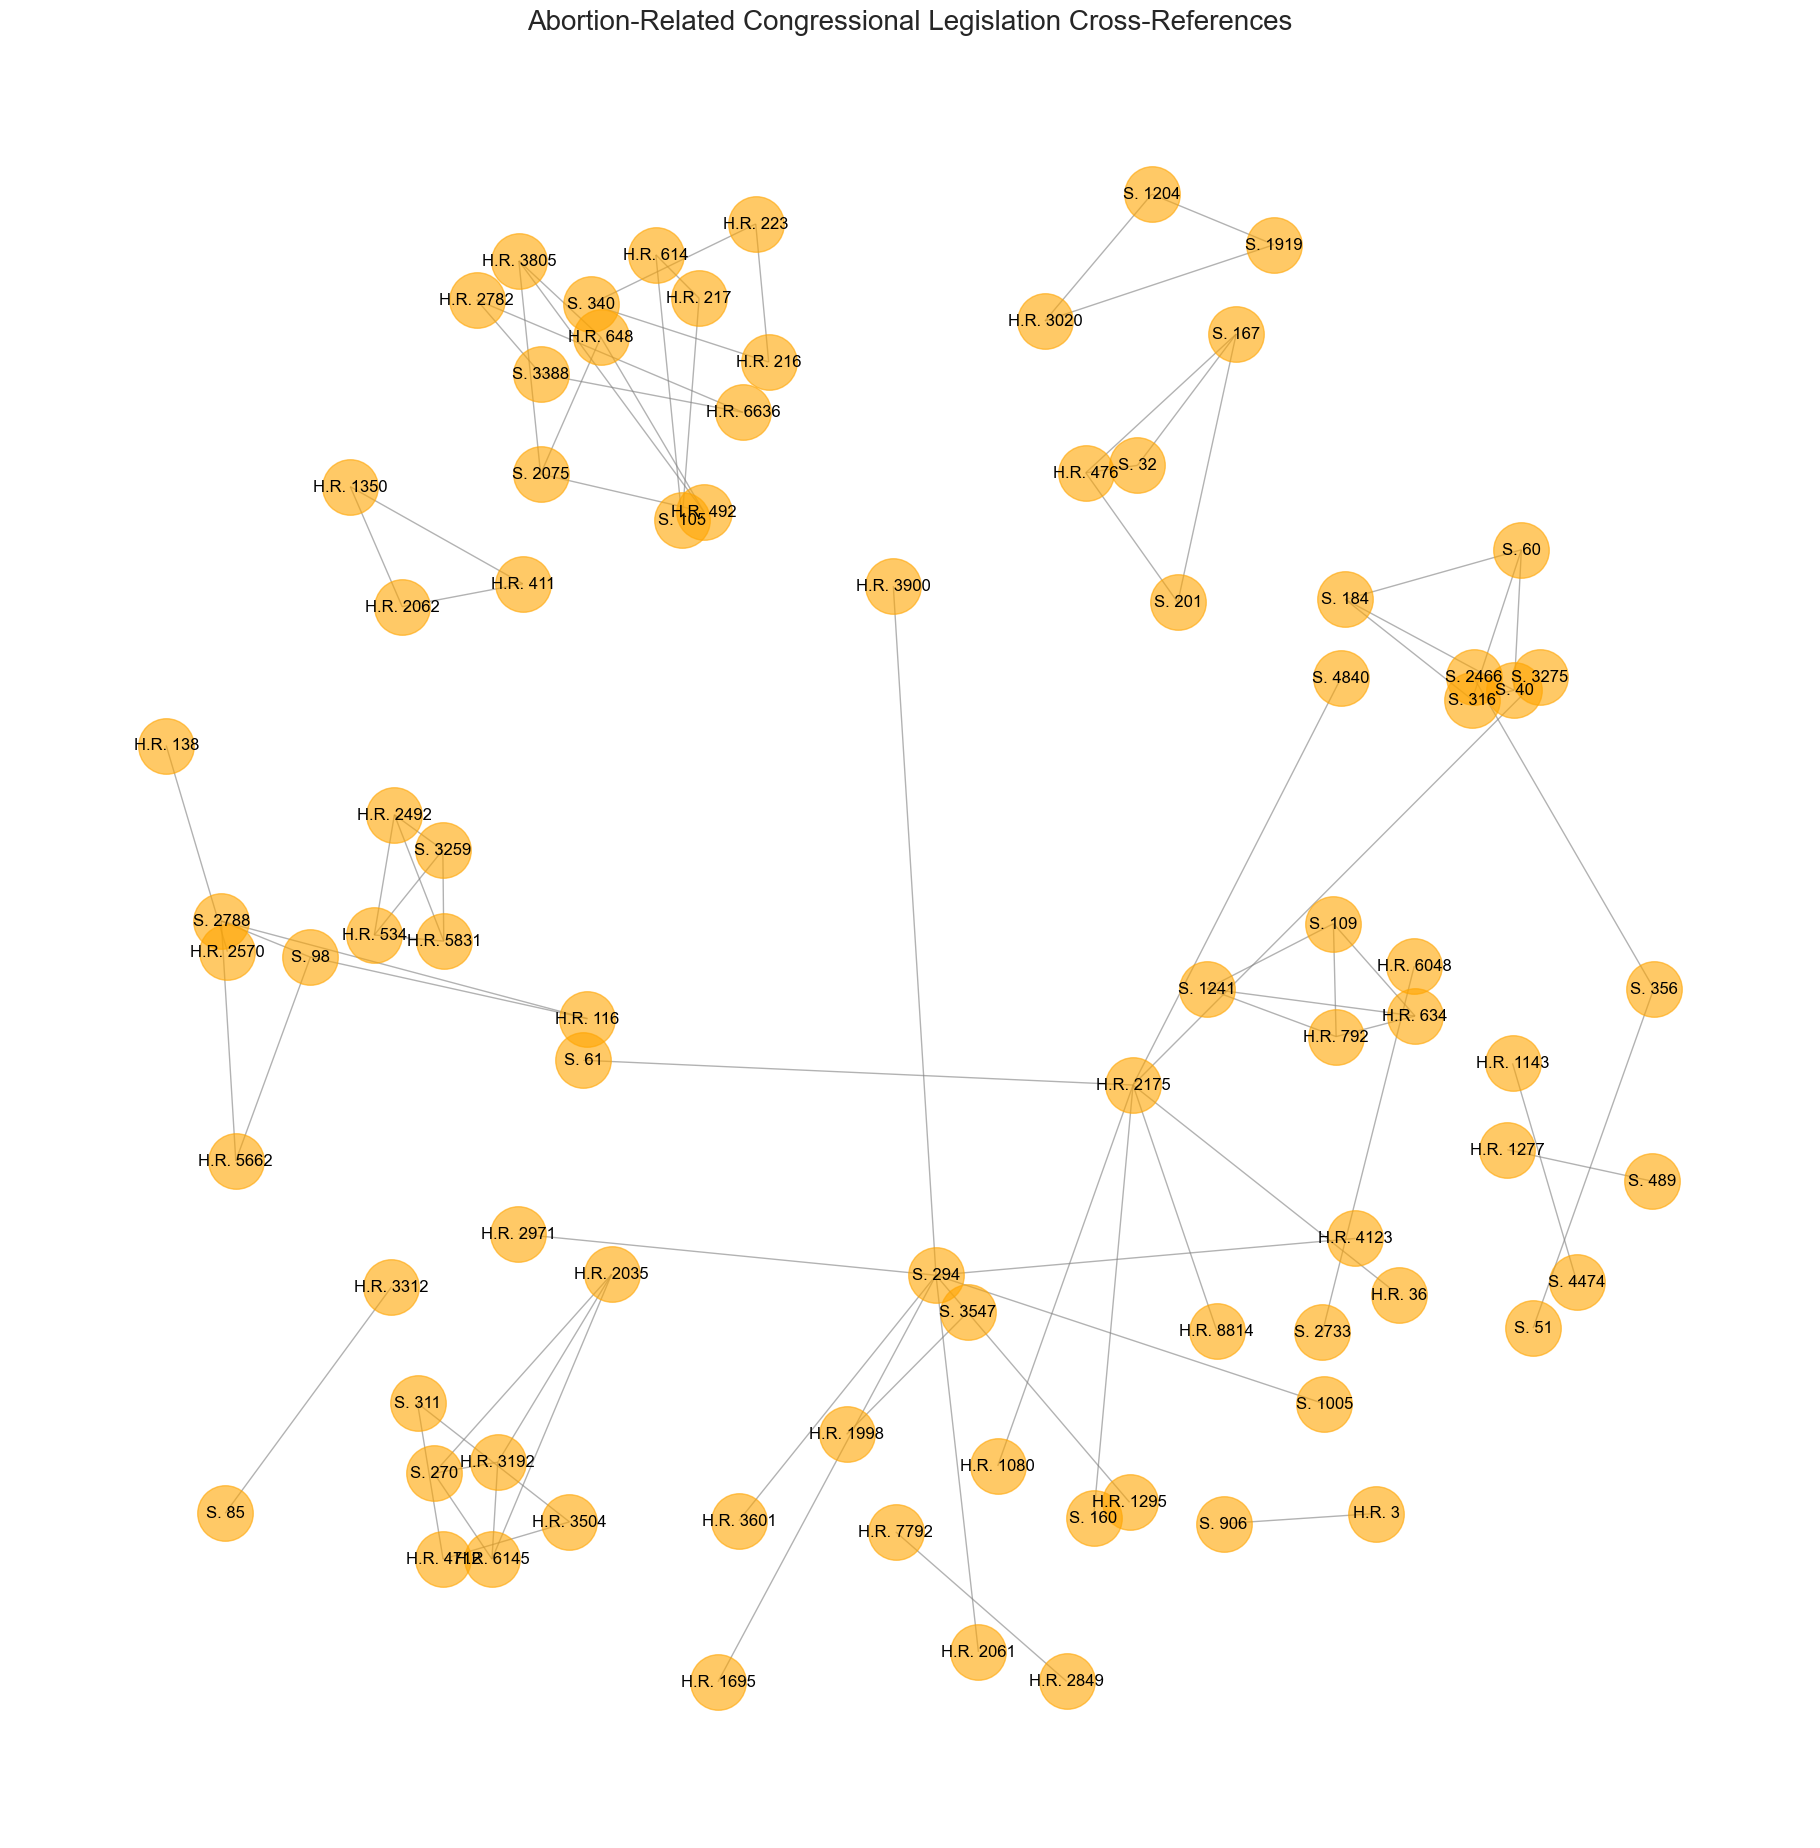

In [18]:
# assuming law_network is your graph
pos = nx.spring_layout(
    law_network, k=0.3, iterations=25
)  # Adjust k for spacing, iterations for layout accuracy

plt.figure(figsize=(18, 18))  # Increase figure size

nx.draw(
    law_network,
    pos,
    node_color="orange",
    node_size=1600,
    font_size=9,
    edge_color="gray",
    alpha=0.6,
)

nx.draw_networkx_labels(law_network, pos)

plt.title("Abortion-Related Congressional Legislation Cross-References", fontsize=20)
plt.show()

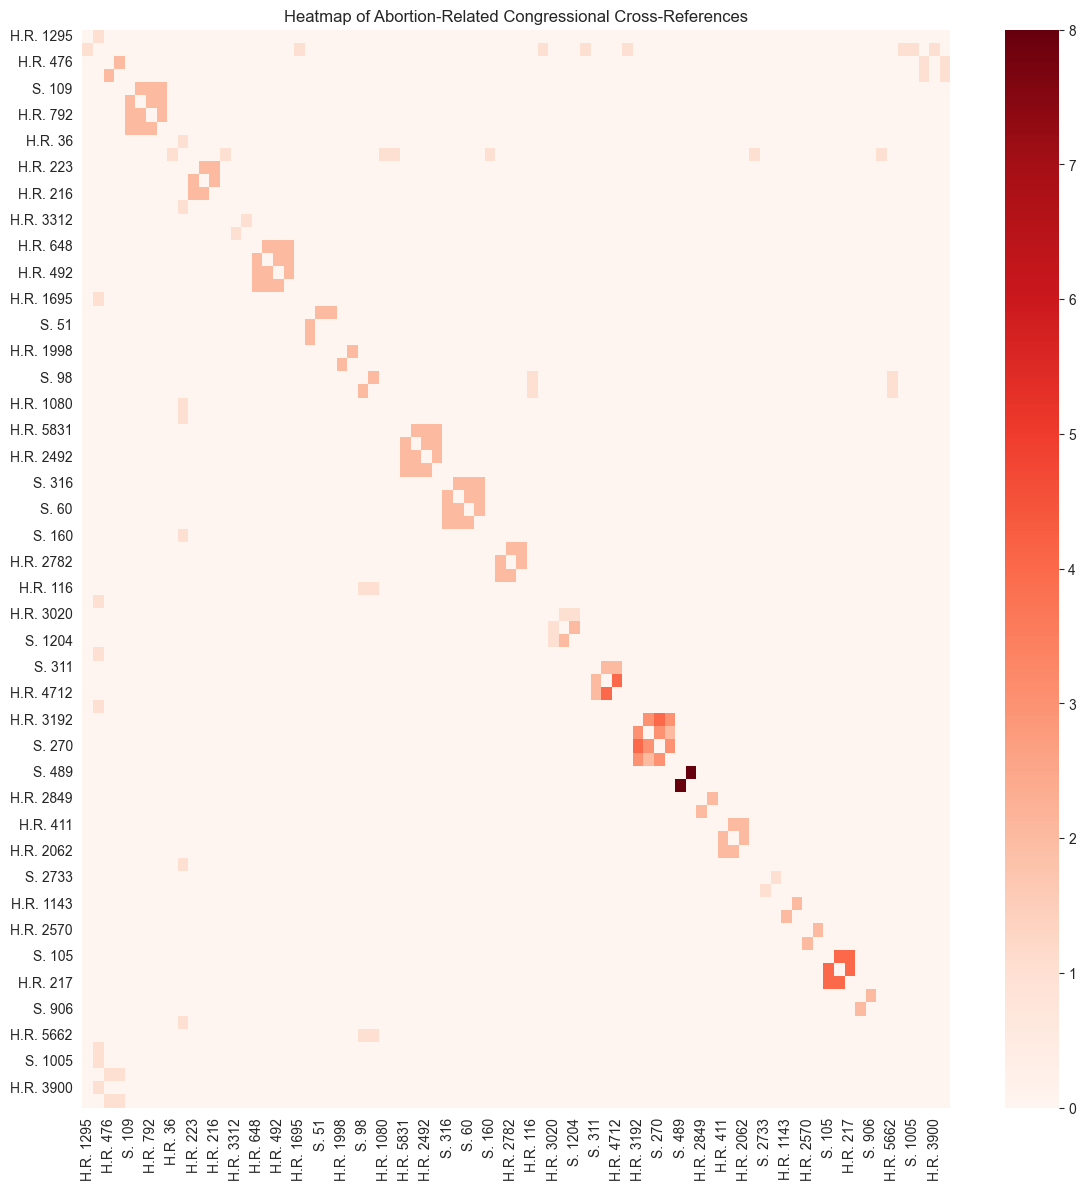

In [19]:
adjacency_matrix_list = []

# Step 1: Filter nodes with edges
nodes_with_edges = [
    node for node in law_network.nodes() if list(law_network.edges(node))
]

# Iterate over each node (law) to build the matrix
for source_node in nodes_with_edges:
    row = []
    for target_node in nodes_with_edges:
        if source_node == target_node:
            row.append(0)  # No self-connections
        elif law_network.has_edge(source_node, target_node):
            # If there's an edge, append its weight
            row.append(law_network.edges[source_node, target_node]["weight"])
        else:
            row.append(0)  # No edge exists
    adjacency_matrix_list.append(row)

# Convert the list to a NumPy array
matrix = np.array(adjacency_matrix_list)

# Create a DataFrame for the heatmap
heatmap_df = pd.DataFrame(matrix, columns=nodes_with_edges, index=nodes_with_edges)

# Plotting
fig = plt.figure(figsize=(14, 14))
ax = sns.heatmap(heatmap_df, cmap="Reds")
plt.title("Heatmap of Abortion-Related Congressional Cross-References")
plt.show()

## <font color="red">*Exercise 3*</font>

<font color="red">Review the documentation for tools and agents from LangChain. Use at 
least two tools with appropriate agents discovered during your review to construct a 
chain addressing questions pertinent to your final project. If your project dataset 
is unsuitable for this task, select an alternative small-sized dataset for 
implementation.

In [7]:
wikipedia_tool = load_tools(["wikipedia"], llm=openai_client)
google_scholar_tool = GoogleScholarQueryRun(api_wrapper=GoogleScholarAPIWrapper())

In [8]:
# create the prompt - copied from https://api.python.langchain.com/en/latest/agents/langchain.agents.react.agent.create_react_agent.html
template = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat 2 times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}"""

prompt = PromptTemplate.from_template(template)

In [9]:
# initialize the agent
agent = create_react_agent(openai_client, wikipedia_tool, prompt)
agent_executor = AgentExecutor(agent=agent, tools=wikipedia_tool)

In [15]:
# choose a random law to get information about
rand_index1 = random.randint(0, len(law_names))
law_names[rand_index1]

'Reproductive Health Information for Veterans Act'

In [16]:
# interact with the agent
agent_executor.invoke(
    {
        "input": f"What was the {law_names[rand_index1]}?",
    }
)["output"]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'The Reproductive Health Information for Veterans Act is a law that aims to provide veterans with comprehensive information and access to services related to their sexual and reproductive health. It is similar to the Responsible Parenthood and Reproductive Health Act of 2012 in the Philippines.'

In [17]:
# choose a different random law to get information about
rand_index2 = random.randint(0, len(law_names))
law_names[rand_index2]

'Safe RESEARCH Act'

In [18]:
# interact with the agent
agent_executor.invoke(
    {
        "input": f"What was the {law_names[rand_index2]}?",
        "chat_history": "Human: I am an abortion legislation researcher.\n",
    }
)["output"]

'The Safe RESEARCH Act does not appear to be a known or official law or act. It is possible that it refers to a proposed or unpublished act or it may be a misnomer for one of the other laws or acts with "Safe" in their name.'

# Scholarly Article Background Tool
Use [SerpAPI](https://serpapi.com/) to get a SERP_API_KEY and set it as an environment variable.

Using LangChain and the Google Scholar tool to get background on a specific abortion-related topic or legislation.

In [19]:
abortion_us = google_scholar_tool.run("Abortion in the US")
print(abortion_us)

Title: Abortion in the US: Barriers to access
Authors: 
Summary: M Gerber Fried - Reproductive Health Matters, 1997 - Taylor & Francis
Total-Citations: 20

Title: US abortion policy and fertility
Authors: 
Summary: JA Klerman - American Economic Review, 1999 - pubs.aeaweb.org
Total-Citations: 48

Title: Characteristics of US abortion patients in 2014 and changes since 2008
Authors: 
Summary: J Jerman, RK Jones, T Onda - 2016 - guttmacher.org
Total-Citations: 300

Title: Self-managed Abortion in the US
Authors: D Grossman
Summary: D Grossman, N Verma - JAMA, 2022 - jamanetwork.com
Total-Citations: 12

Title: Abortion in the United States: barriers to access
Authors: 
Summary: MG Fried - Health and Human Rights, 2000 - JSTOR
Total-Citations: 37

Title: At what cost? Payment for abortion care by US women
Authors: TA Weitz
Summary: RK Jones, UD Upadhyay, TA Weitz - Women's Health Issues, 2013 - Elsevier
Total-Citations: 179

Title: The safety and quality of abortion care in the United Stat

In [20]:
# Grabbing a Google Scholar article about abortion
anti_abortion_leg = google_scholar_tool.run("Anti-abortion Legislation")
print(anti_abortion_leg)

Title: Analyzing the effect of anti-abortion US state legislation in the post-Casey era
Authors: 
Summary: MJ New - State Politics & Policy Quarterly, 2011 - cambridge.org
Total-Citations: 61

Title: Gender and ideology in the spread of anti-abortion policy
Authors: AX Zhang,S Counts
Summary: AX Zhang, S Counts - Proceedings of the 2016 CHI Conference on …, 2016 - dl.acm.org
Total-Citations: 17

Title: Anti-abortion laws gain more ground in the USA
Authors: 
Summary: A Gee - The Lancet, 2011 - thelancet.com
Total-Citations: 11

Title: Abortion as a Public Health Risk in Covid-19 Anti-Abortion Legislation
Authors: S Carson,SK Carter
Summary: S Carson, SK Carter - Journal of Health Politics, Policy and …, 2023 - read.dukeupress.edu
Total-Citations: 2

Title: A narrative analysis of anti-abortion testimony and legislative debate related to Georgia's fetal “heartbeat” abortion ban
Authors: DP Evans,S Narasimhan
Summary: DP Evans, S Narasimhan - Sexual and Reproductive Health …, 2020 - Tayl

In [21]:
# Grabbing a Google Scholar article about abortion
abortion_partisanship = google_scholar_tool.run("Abortion and the Supreme Court")
print(abortion_partisanship)

Title: An American Tragedy: The Supreme Court on Abortion
Authors: 
Summary: RM Byrn - Fordham L. Rev., 1972 - HeinOnline
Total-Citations: 224

Title: Republican schoolmaster: The US Supreme Court, public opinion, and abortion
Authors: 
Summary: CH Franklin, LC Kosaki - American Political Science Review, 1989 - cambridge.org
Total-Citations: 434

Title: Media agendas and human rights: The Supreme Court decision on abortion
Authors: JC Pollock
Summary: JC Pollock, JL Robinson Jr… - Journalism …, 1978 - journals.sagepub.com
Total-Citations: 66

Title: Abortion and the Supreme Court: The Retreat from Roe v. Wade
Authors: W Dellinger
Summary: W Dellinger, GB Sperling - U. Pa. L. Rev., 1989 - HeinOnline
Total-Citations: 94

Title: The Supreme Court, the Texas abortion law (SB8), and the beginning of the end of Roe v Wade?
Authors: EY Adashi,LO Gostin
Summary: IG Cohen, EY Adashi, LO Gostin - JAMA, 2021 - jamanetwork.com
Total-Citations: 27

Title: The Supreme Court and abortion rights
Autho

**Observations:** The use of LangChain would be extremely helpful for abortion-related legislation 
research by providing the ability to get a general overview of a specific legislation 
or body of legislation, as well as scholarly articles about different topics within 
the abortion literature.

## <font color="red">*Exercise 4*</font>

<font color="red">Use LangChain(you're welcome to not use it) to set up conversations with LLM 
agents for questions related to your final project (if relevant), or think of a 
scenario that a simulated conversation could be useful to answer a research question 
and find a dataset to implement it. What does it reveal about the social game involved 
with your dataset?

<font color="red"> Stretch: Use the idea of memory retrieval(or other methods) to design better 
templates for the LLM conversation.

In [ ]:
%pip install openai==0.28.0
%pip install langchain==0.0.316

In [4]:
scotus_df = pd.read_feather("data/scotus_cases_clustered.fea")
scotus_df.head()

,title,case_url,author,author_url,description,pdf_url,raw_text,cleaned_text,tokenized_text_sents,tokenized_text_words,tokenized_text_words_norm,text_pos,text_pos_tags_of_interest,joined_text_pos_tags_of_interest,knn_clusters
0,Dobbs v. Jackson Women's Health Organization,https://supreme.justia.com/cases/federal/us/59...,"Samuel A. Alito, Jr.",https://supreme.justia.com/justices/samuel-a-a...,The Constitution does not confer a right to ab...,https://supreme.justia.com/cases/federal/us/59...,\n \n \n \n \n \n \n \n \n \n \n ...,"1 (Slip Opinion) OCTOBER TERM, 2021 Syllabus N...","[1 (slip opinion) october term, 2021 syllabus ...","[slip, opinion, october, term, syllabus, note,...","[slip, opinion, october, term, syllabus, note,...","[[1, X], [(, PUNCT], [Slip, PROPN], [Opinion, ...","[feasible, syllabus, headnote, released, done,...",feasible syllabus headnote released done conne...,0
1,Whole Woman's Health v. Hellerstedt,https://supreme.justia.com/cases/federal/us/57...,Stephen Breyer,https://supreme.justia.com/justices/stephen-br...,Two restrictions imposed by a Texas abortion l...,https://supreme.justia.com/cases/federal/us/57...,\n \n \n \n \n \n \n \n \n \n \n \n \...,"1 (Slip Opinion) OCTOBER TERM, 2015 Syllabus N...","[1 (slip opinion) october term, 2015 syllabus ...","[slip, opinion, october, term, syllabus, note,...","[slip, opinion, october, term, syllabus, note,...","[[1, X], [(, PUNCT], [Slip, PROPN], [Opinion, ...","[feasible, syllabus, headnote, released, done,...",feasible syllabus headnote released done conne...,0
2,Gonzales v. Carhart,https://supreme.justia.com/cases/federal/us/55...,Anthony Kennedy,https://supreme.justia.com/justices/anthony-ke...,"When it has a rational basis to act, and it do...",https://supreme.justia.com/cases/federal/us/55...,"(Bench Opinion) OCTOBER TERM, 2006 1 \n \nSyl...","(Bench Opinion) OCTOBER TERM, 2006 1 Syllabus ...","[(bench opinion) october term, 2006 1 syllabus...","[bench, opinion, october, term, syllabus, note...","[bench, opinion, october, term, syllabus, note...","[[(, PUNCT], [Bench, PROPN], [Opinion, PROPN],...","[NOTE, feasible, syllabus, headnote, released,...",NOTE feasible syllabus headnote released done ...,5
3,Stenberg v. Carhart,https://supreme.justia.com/cases/federal/us/53...,Stephen Breyer,https://supreme.justia.com/justices/stephen-br...,A state law criminalizing the performance of p...,https://supreme.justia.com/cases/federal/us/53...,530US2 Unit: $U85 [11-21-01 16:51:50] PAGES PG...,530US2 Unit: U85 [11-21-01 16:51:50] PAGES PGT...,"[530us2 unit: u85, [11-21-01 16:51:50] pages p...","[530us2, unit, u85, 16:51:50, pages, pgt, o, p...","[530us2, unit, u85, 16:51:50, page, pgt, o, pi...","[[530US2, NUM], [Unit, NOUN], [:, PUNCT], [U85...","[Unit, STEN, eighth, circuit, Argued, offers, ...",Unit STEN eighth circuit Argued offers basic p...,5
4,Planned Parenthood of Southeastern Pennsylvani...,https://supreme.justia.com/cases/federal/us/50...,Anthony Kennedy,https://supreme.justia.com/justices/anthony-ke...,"An undue burden exists, and therefore a provis...",https://supreme.justia.com/cases/federal/us/50...,505us3u117 07-09-96 09:34:02 PAGES OPINPGT\n83...,505us3u117 07-09-96 09:34:02 PAGES OPINPGT 833...,[505us3u117 07-09-96 09:34:02 pages opinpgt 83...,"[505us3u117, 09:34:02, pages, opinpgt, october...","[505us3u117, 09:34:02, page, opinpgt, october,...","[[505us3u117, NUM], [07, NUM], [-, PUNCT], [09...","[PLANNED, PARENTHOOD, appeals, third, circuit,...",PLANNED PARENTHOOD appeals third circuit No Ar...,0


In [9]:
# To get this to run, I had to use openai v0.28.0 and
# langchain v0.0.316.
decision_history = []
ai_history = []
decision_list = scotus_df["description"].tolist()
scotus_llm_prompt = create_chat_prompt(decision_history, ai_history)
chain = LLMChain(
    llm=OpenAI(temperature=0.9, model_name="gpt-3.5-turbo-instruct"),
    prompt=scotus_llm_prompt,
)

In [11]:
for d in decision_list[:10]:
    decision_history.append(d)
    ai_history.append(
        query_chain(
            chain,
            f"Consider this text and the previous texts that I've sent, and give me a list of the most important topics given all of excerpts you've been sent thus far: {d}",
        )
    )
print(
    query_chain(
        chain,
        "Could you provide a list of the most important topics covered in our previous conversations, as well as a list of changes you've seen in the ways the text has talked about abortion?",
    )
)



AI: Sure, here are the most important topics that have been covered in our previous conversations: Supreme Court decisions, SCOTUS, important topics, text, and abortion.

As for changes in the ways the text has talked about abortion, I have noticed a shift towards more discussion of reproductive rights and access to healthcare, as well as increased focus on the impact of legislation on marginalized communities. There also seems to be a growing recognition of the complexities and nuances surrounding the issue of abortion.


**Observations:** The previous 'most important' topics feel like they were not SUPER relevant, sans
the inclusion of abortion. Regarding the change in focus on abortion, I actually think this is quite
useful. While the chatbot's observations are the ones I'd assume, but there's some comfort seeing
those validated by the LLM.